In [32]:
import numpy
import xarray
import rioxarray
import geopandas
import fim_utils as fim
from pathlib import Path
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

## Collect Data

Collect the required input FIM data that is staged on CUAHSI's MinIO server.

In [ ]:
# hydroTable_0.csv
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/16010102/branches/0/hydroTable_0.csv .

# rem_zeroed_masked_0.tif
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/16010102/branches/0/rem_zeroed_masked_0.tif .

# gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
s3 cp s3://scratch/hand_fim/16010102/branches/0/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg .

Define a feature of interest and a hypothetical streamflow

In [4]:
nhd_feature_id=946010122
cms = 400

Collect stage for all hydroids in this NHD+ feature. Use the hypothetical stage defined above to interpolate river stage from a rating curve.

In [5]:
stage_dict = fim.get_stage_for_all_hydroids_in_reach(nhd_feature_id, cms)

Load the precomputed HAND raster.

In [7]:
def get_hand_object(path):
    return rioxarray.open_rasterio(path, masked=True).squeeze().drop('band').to_dataset(name='hand')

xds = get_hand_object(Path('./rem_zeroed_masked_0.tif'))

Make a copy of the 'hand' variable to the 'stage' variable. This will be used to compute the flood inundation map.

In [8]:
xds['stage'] = xds.hand.copy(deep=True)
#xds
#xds.hand.plot()

Read watershed geometries and set stage values from the `stage_dict` defined above. Remove all other geometries.

In [9]:
geodf = geopandas.read_file(Path('./gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg'))

for hydroid, stage in stage_dict.items():
    geodf.loc[geodf.HydroID==hydroid, 'stage'] = stage

geodf_filtered = geodf[geodf.stage.notnull()]

geodf_filtered

,HydroID,S0,LengthKm,LakeID,From_Node,To_Node,NextDownID,areasqkm,feature_id,order_,src_calibrated,geometry,stage
739,27670089,0.001,1.483675,-999.0,482,483,27670090,1.1719,946010122,4,False,"POLYGON ((-1232420.591 2239254.282, -1232330.5...",8.377581
741,27670090,0.001,1.484386,-999.0,483,484,27670091,0.7458,946010122,4,False,"POLYGON ((-1231460.591 2238294.282, -1231430.5...",7.632694
755,27670091,0.001,1.481960,-999.0,484,485,27670092,2.9765,946010122,4,False,"POLYGON ((-1232760.591 2239874.282, -1232750.5...",6.922888
767,27670092,0.001,1.481249,-999.0,485,486,27670093,1.7645,946010122,4,False,"POLYGON ((-1230330.591 2237484.282, -1230320.5...",5.436255
789,27670093,0.001,1.482254,-999.0,486,487,27670094,0.5658,946010122,4,False,"POLYGON ((-1231370.591 2236004.282, -1231360.5...",5.385274
801,27670094,0.001,1.477817,-999.0,487,488,27670095,4.0446,946010122,4,False,"POLYGON ((-1232910.591 2237134.282, -1232900.5...",4.714165
807,27670095,0.001,1.479533,-999.0,488,489,27670096,0.2295,946010122,4,False,"POLYGON ((-1231410.591 2234414.282, -1231380.5...",6.200348


Add these geometries to the HAND and Stage DataSet using a GeoCube.

In [11]:

# create a grid for the geocube
out_grid = make_geocube(
    vector_data=geodf,
    measurements=['HydroID'],
    like=xds # ensure the data are on the same grid
)


In [12]:
# add stage and hydroID to the HAND raster
#xds = xds.assign_coords( hydroid = (['y', 'x'], out_grid.HydroID.data) )
ds = xds.assign_coords( hydroid = (['y', 'x'], out_grid.HydroID.data) )

# drop everything except the HydroIDs that we're interested in
ds = ds.where(ds.hydroid.isin(geodf_filtered.HydroID), drop=True)

Update the stage values in the DataSet where specific hydroid's exist.

In [13]:
for idx, row in geodf_filtered.iterrows():
    print(f'{row.HydroID} -> {row.stage}' )
    ds['stage'] = xarray.where(ds.hydroid == row.HydroID, row.stage, ds.stage)

27670089 -> 8.377581036379878
27670090 -> 7.632693544721404
27670091 -> 6.922887904622214
27670092 -> 5.436255044346741
27670093 -> 5.385274174346444
27670094 -> 4.7141651772300275
27670095 -> 6.200347554996581


Preview the `stage` data we set as well as the original `hand` data.

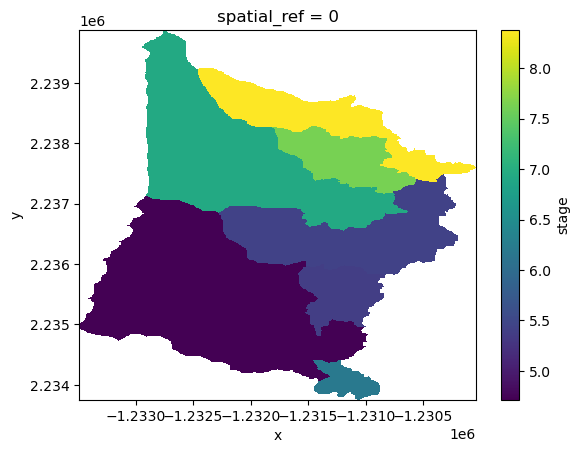

In [14]:
ds.stage.plot()

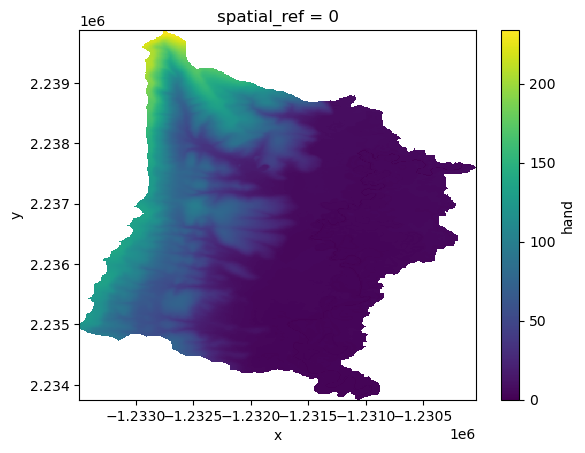

In [15]:
ds.hand.plot()

Compute FIM by subtracting `hand` from `stage`. Everything that is negative should be set to zero.

In [24]:
ds['fim'] = ds.stage - ds.hand
ds['fim'] = xarray.where(ds.fim >= 0.00001, ds.fim, numpy.nan)

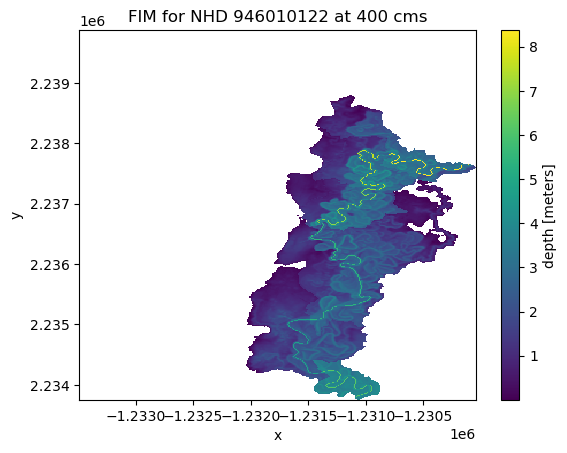

In [33]:

_ = ds.fim.plot(cbar_kwargs={'label':'depth [meters]'})
_ = plt.title(f'FIM for NHD {nhd_feature_id} at {cms} cms')